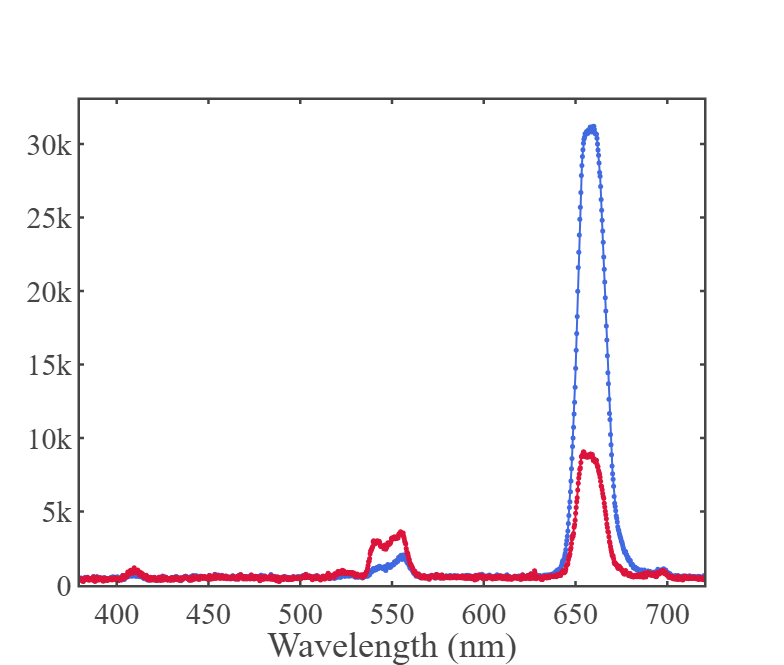

Saved figure: C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper\PL_comparison_NaBiF4_NaYF4.png


In [83]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import os

# ============================================================
# --- File paths ---
# ============================================================
file1 = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\PL\19 nov nabif4\NaBiF4_500ms\975nm_80mW.txt"
file2 = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\PL\19 nov nabif4\NaYF4\80mW.txt"

# ============================================================
# --- Load Data ---
# Assumes 2 columns: wavelength intensity
# ============================================================
def load_txt(path):
    data = np.loadtxt(path)
    return data[:, 0], data[:, 1]

wl1, I1 = load_txt(file1)
wl2, I2 = load_txt(file2)

# ============================================================
# --- Custom Plotly Template ---
# ============================================================
fig_template = go.layout.Template()
fig_template.layout = {
    'template': 'simple_white+presentation',
    'autosize': False,
    'width': 800,
    'height': 600,
    'xaxis': {
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 2.5,
        'tickwidth': 2.5,
        'ticklen': 4,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white',
    },
    'yaxis': {
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 2.5,
        'tickwidth': 2.5,
        'ticklen': 4,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white',
    },
    'font': {
        'family': 'mathjax',
        'size': 30,
    }
}

# ============================================================
# --- Plot ---
# ============================================================
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=wl1, y=I1,
    mode='lines+markers',
    name='NaBiF4 (80 mW, 500 ms)',
    line=dict(color='royalblue', width=2),
    marker=dict(size=5,
                # symbol='circle'
               ),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=wl2, y=I2,
    mode='lines+markers',
    name='NaYF4 (80 mW)',
    line=dict(color='crimson', width=2),
    marker=dict(size=5,
                # symbol='circle'
               ),
    showlegend=False
))

fig.update_layout(
    template=fig_template,
    width=800,
    height=650,
    xaxis_title="Wavelength (nm)",
    # yaxis_title="Intensity (a.u.)",
    xaxis=dict(range=[380, 720]),
    yaxis=dict(range=[0, 33000]),
)

fig.show()

# ============================================================
# --- Save figure ---
# ============================================================
output_fig_folder = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper"
os.makedirs(output_fig_folder, exist_ok=True)
out_path = os.path.join(output_fig_folder, "PL_comparison_NaBiF4_NaYF4.png")
pio.write_image(fig, out_path, scale=4)
print("Saved figure:", out_path)


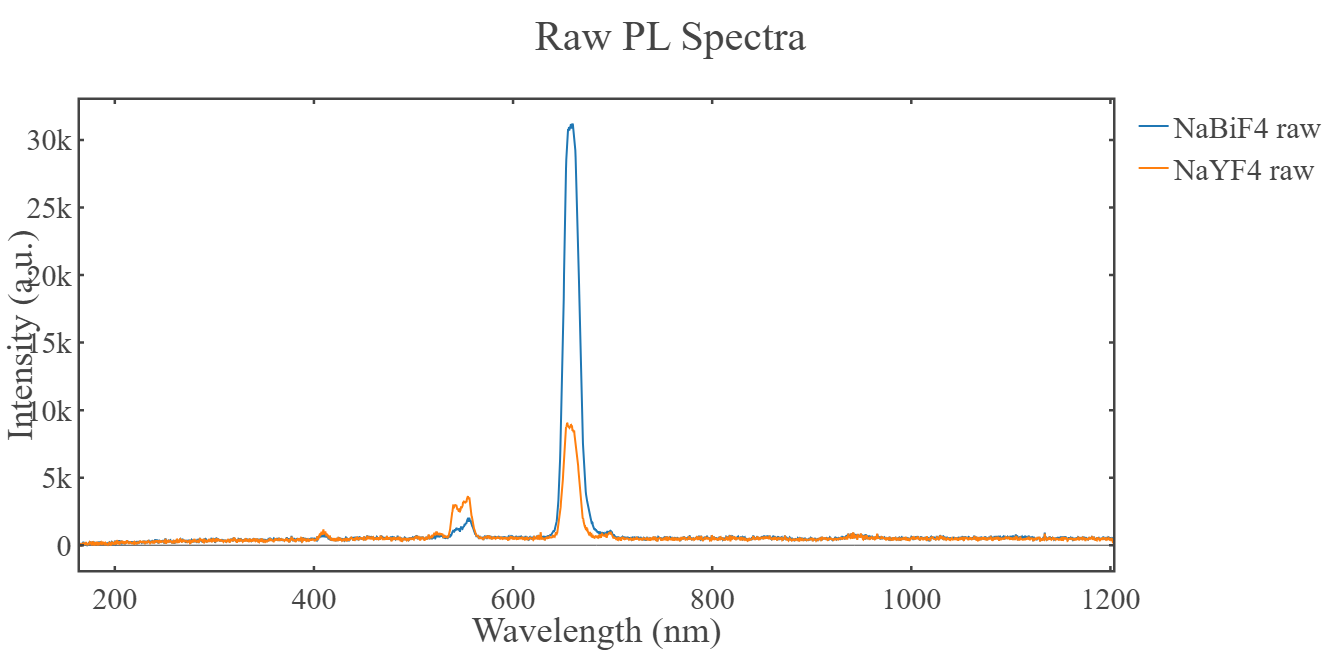

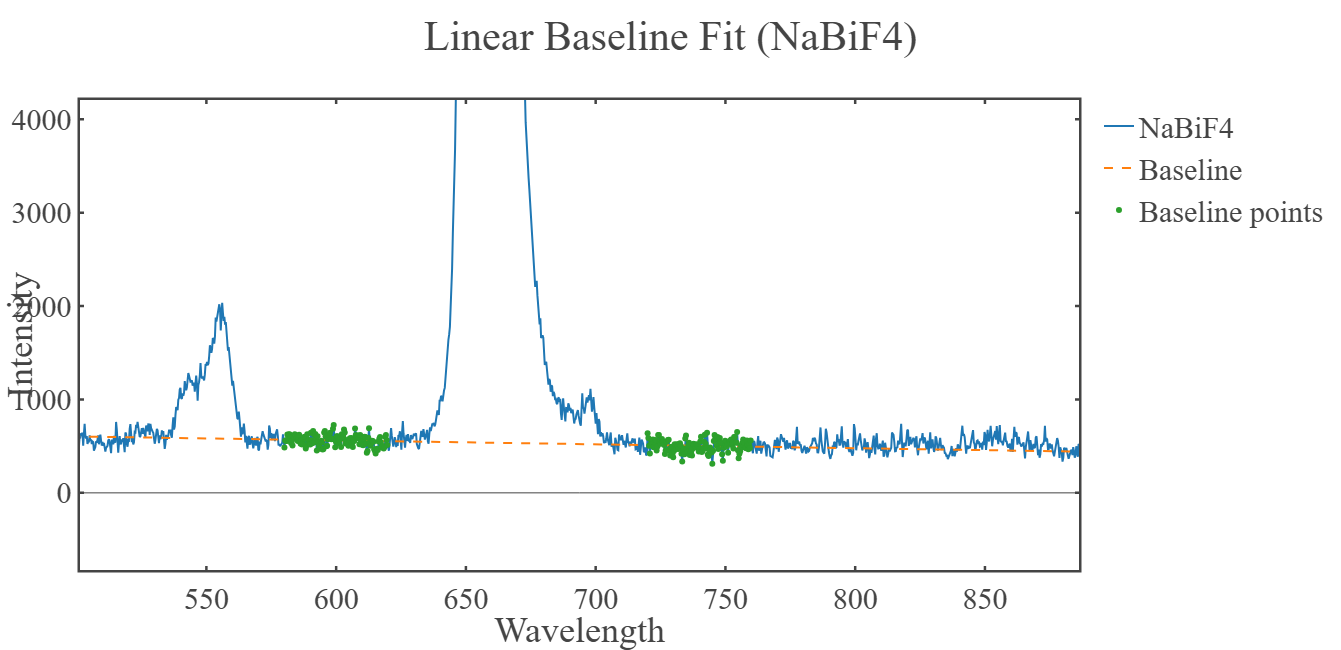

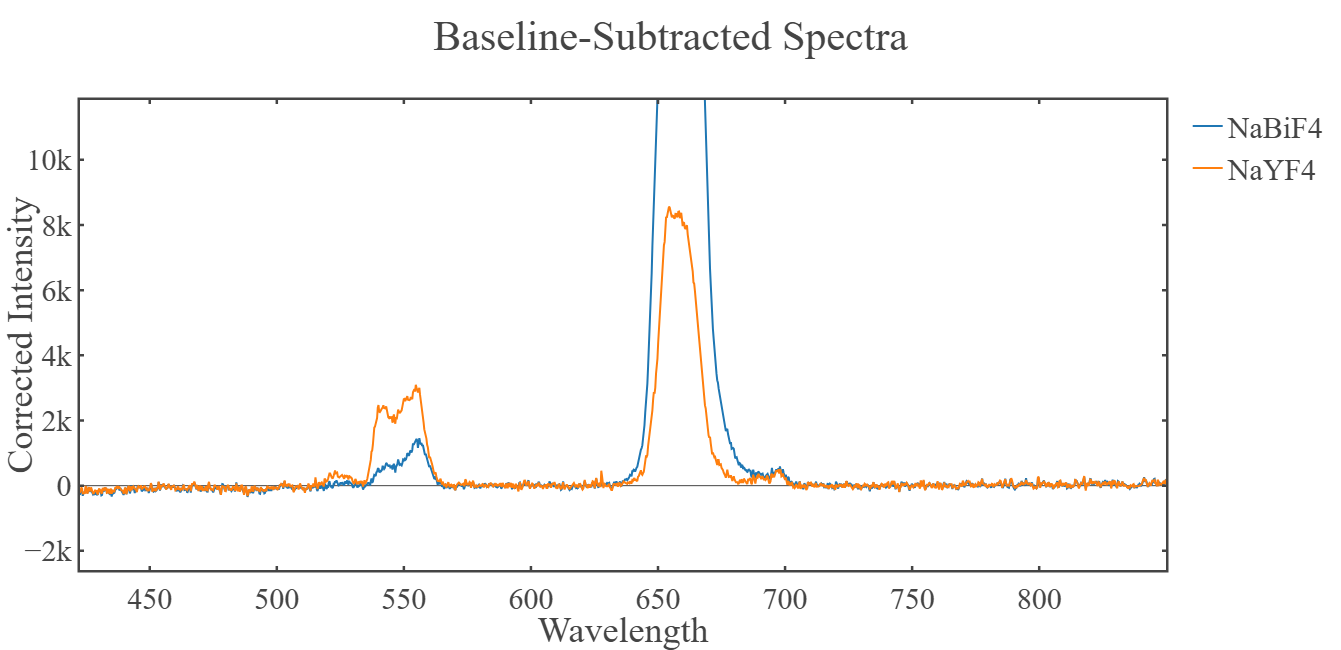

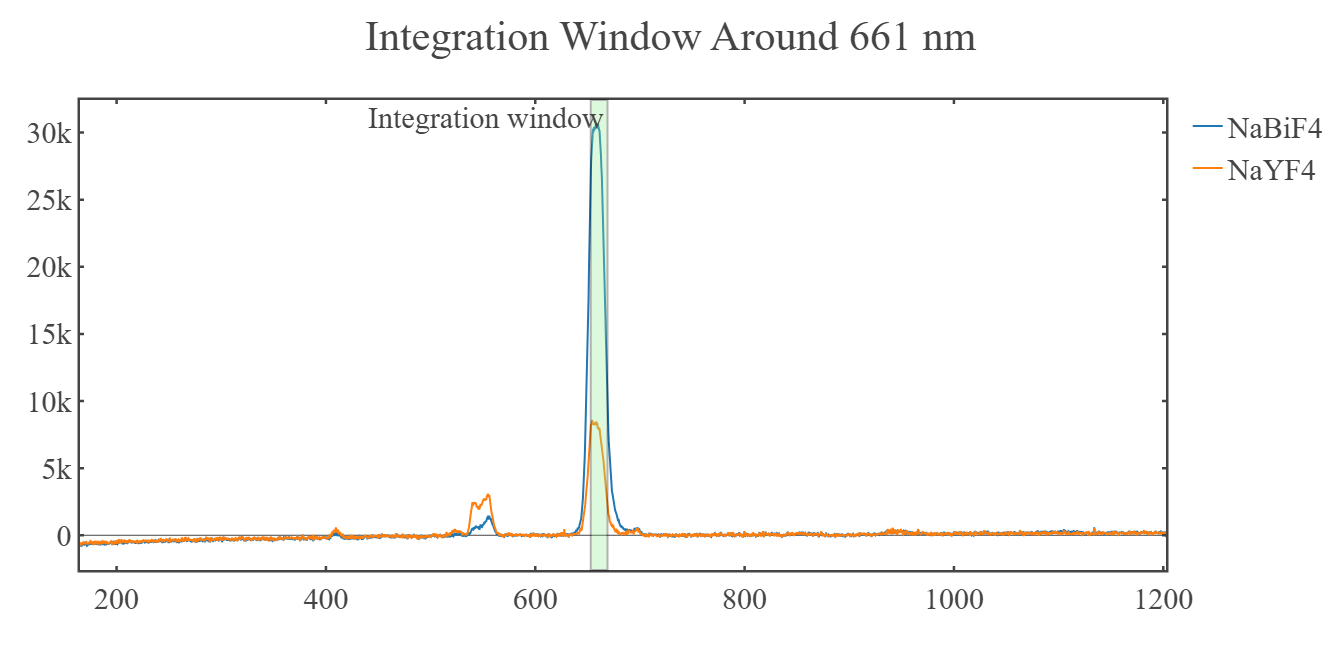

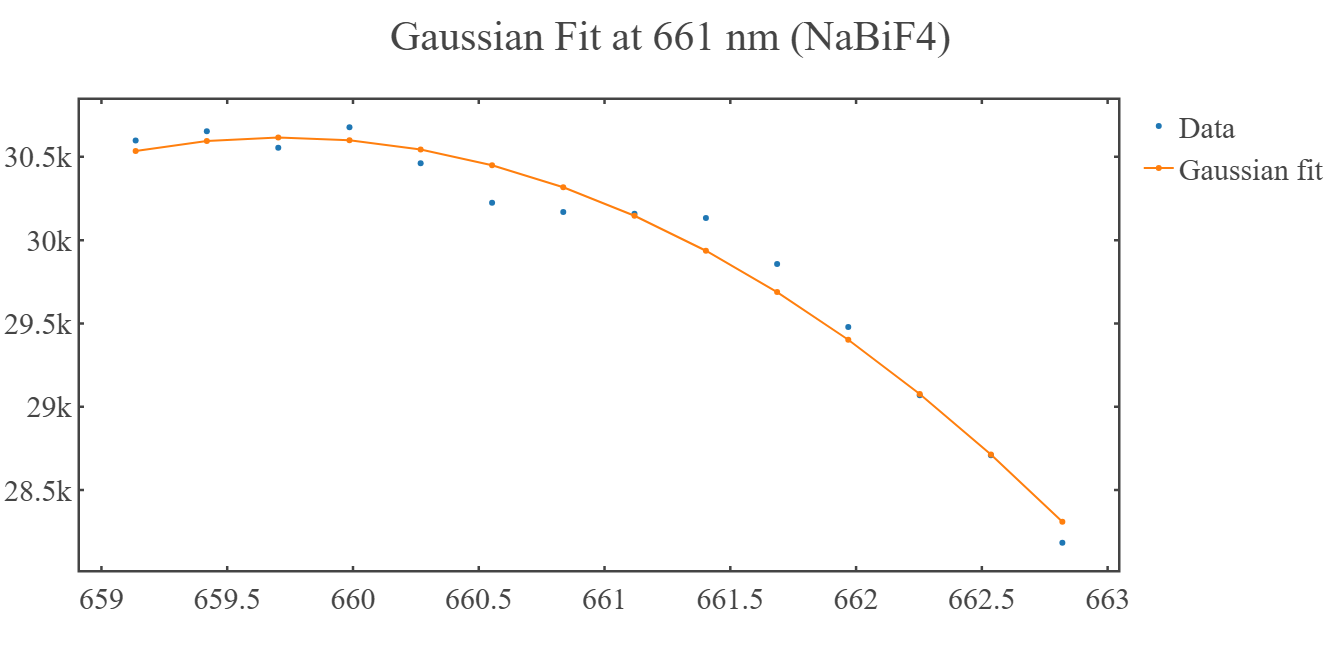

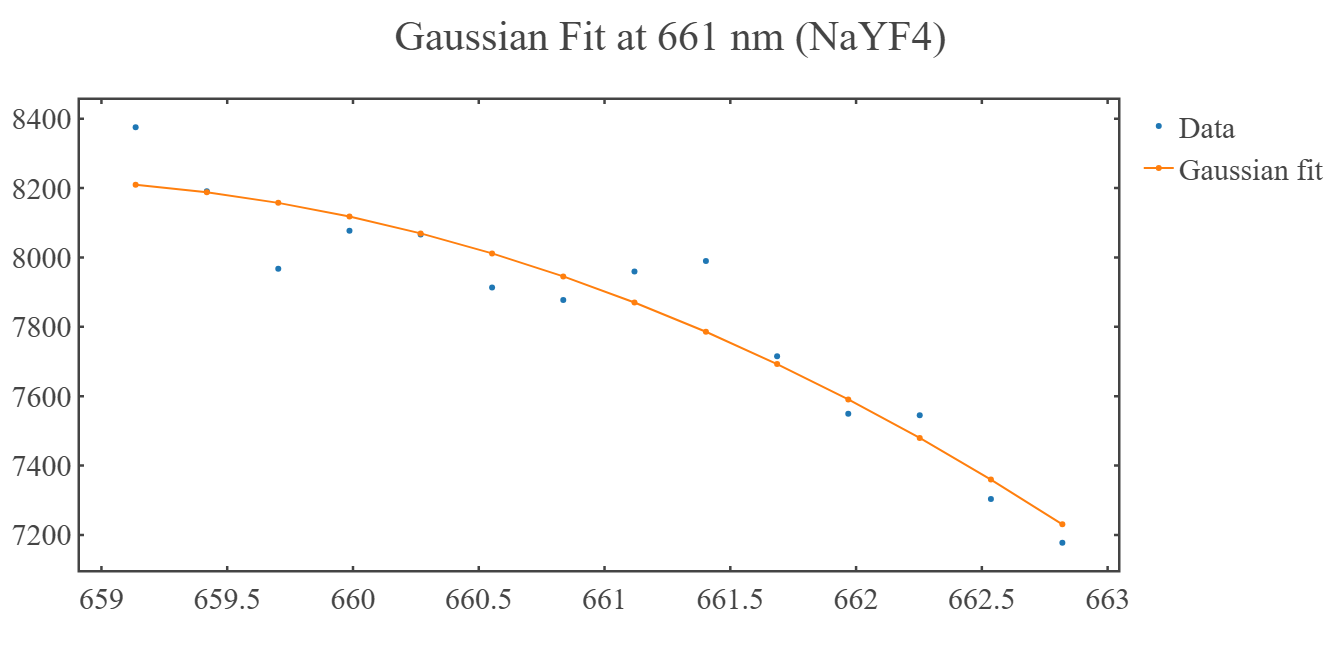


=== Final Results ===
Normalized I (NaBiF4): 3920 ± 1.258
Normalized I (NaYF4): 1031 ± 1.269

Ratio I1/I2 = 3.803 ± 0.005
Percent difference = 280.27% ± 0.48%


In [37]:
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import plotly.graph_objects as go

# ============================================================
# --- File paths ---
# ============================================================
file1 = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\PL\19 nov nabif4\NaBiF4_500ms\975nm_80mW.txt"
file2 = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\PL\19 nov nabif4\NaYF4\80mW.txt"

def load_txt(path):
    data = np.loadtxt(path)
    return data[:,0], data[:,1]

wl1, I1 = load_txt(file1)
wl2, I2 = load_txt(file2)

# ============================================================
# --- USER PARAMETERS ---
# ============================================================
target_wl = 661.0
half_width = 8.0
baseline_left = (580, 620)
baseline_right = (720, 760)
power1_mW = 13
power2_mW = 13
exposure1_ms = 500.0
exposure2_ms = 500.0

# ============================================================
# --- Custom Plotly Template ---
# ============================================================
fig_template = go.layout.Template()
fig_template.layout = {
    'template': 'simple_white+presentation',
    'autosize': False,
    'width': 800,
    'height': 600,
    'xaxis': {
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 2.5,
        'tickwidth': 2.5,
        'ticklen': 4,
        'showline': True,
        'showgrid': False,
    },
    'yaxis': {
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 2.5,
        'tickwidth': 2.5,
        'ticklen': 4,
        'showline': True,
        'showgrid': False,
    },
    'font': {
        'family': 'mathjax',
        'size': 30,
    }
}

# ============================================================
# --- Helper Functions ---
# ============================================================
def linear_baseline_subtract(wl, I, left_range, right_range):
    mask_left = (wl >= left_range[0]) & (wl <= left_range[1])
    mask_right = (wl >= right_range[0]) & (wl <= right_range[1])
    mask = mask_left | mask_right
    p = np.polyfit(wl[mask], I[mask], 1)
    baseline = np.polyval(p, wl)
    I_corr = I - baseline
    noise = np.std(I[mask] - np.polyval(p, wl[mask]))
    return I_corr, p, noise, baseline, mask

def integrate_window(wl, I, center, half_width):
    left = center - half_width
    right = center + half_width
    mask = (wl >= left) & (wl <= right)
    area = np.trapz(I[mask], wl[mask])
    avg_height = area / (2 * half_width)
    return avg_height, area, mask

def gaussian(x, a, mu, sigma, c):
    return a * np.exp(-0.5 * ((x - mu) / sigma)**2) + c

def fit_gaussian_near(wl, I, center, fit_half_width=2.0):
    mask = (wl >= center - fit_half_width) & (wl <= center + fit_half_width)
    x = wl[mask]; y = I[mask]
    if len(x) < 5:
        return None
    a0 = np.max(y)
    mu0 = x[np.argmax(y)]
    sigma0 = 0.6
    c0 = np.min(y)
    try:
        popt, pcov = curve_fit(gaussian, x, y, p0=[a0, mu0, sigma0, c0], maxfev=5000)
        return popt, np.sqrt(np.diag(pcov)), x, y
    except:
        return None

# ============================================================
# --- Apply Baseline Subtraction ---
# ============================================================
I1_corr, p1, noise1, baseline1, mask1 = linear_baseline_subtract(wl1, I1, baseline_left, baseline_right)
I2_corr, p2, noise2, baseline2, mask2 = linear_baseline_subtract(wl2, I2, baseline_left, baseline_right)

# ============================================================
# --- Integration ---
# ============================================================
avg_h1, area1, intmask1 = integrate_window(wl1, I1_corr, target_wl, half_width)
avg_h2, area2, intmask2 = integrate_window(wl2, I2_corr, target_wl, half_width)

# ============================================================
# --- Gaussian Fit ---
# ============================================================
g1 = fit_gaussian_near(wl1, I1_corr, target_wl)
g2 = fit_gaussian_near(wl2, I2_corr, target_wl)

# ============================================================
# --- Normalization ---
# ============================================================
exp1_s = exposure1_ms / 1000
exp2_s = exposure2_ms / 1000

I1_norm = avg_h1 / (power1_mW * exp1_s)
I2_norm = avg_h2 / (power2_mW * exp2_s)

sigma_h1 = noise1 / np.sqrt(len(wl1[intmask1]))
sigma_h2 = noise2 / np.sqrt(len(wl2[intmask2]))

sigma_I1_norm = sigma_h1 / (power1_mW * exp1_s)
sigma_I2_norm = sigma_h2 / (power2_mW * exp2_s)

ratio = I1_norm / I2_norm
sigma_ratio = ratio * np.sqrt((sigma_I1_norm/I1_norm)**2 + (sigma_I2_norm/I2_norm)**2)

percent_diff = (I1_norm - I2_norm) / I2_norm * 100
sigma_percent_diff = np.sqrt(sigma_I1_norm**2 + (I1_norm/I2_norm * sigma_I2_norm)**2) / I2_norm * 100

# ============================================================
# === PLOTS (with fig_template)
# ============================================================

# 1. Raw spectra
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=wl1, y=I1, mode="lines", name="NaBiF4 raw"))
fig1.add_trace(go.Scatter(x=wl2, y=I2, mode="lines", name="NaYF4 raw"))
fig1.update_layout(
    template=fig_template,title="Raw PL Spectra",
                   width=800, height=650,
                   xaxis_title="Wavelength (nm)",
                   yaxis_title="Intensity (a.u.)")
fig1.show()

# 2. Baseline estimation
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=wl1, y=I1, mode="lines", name="NaBiF4"))
fig2.add_trace(go.Scatter(x=wl1, y=baseline1, mode="lines",
                          name="Baseline", line=dict(dash="dash")))
fig2.add_trace(go.Scatter(x=wl1[mask1], y=I1[mask1],
                          mode="markers", name="Baseline points"))
fig2.update_layout(template=fig_template,title="Linear Baseline Fit (NaBiF4)",
                   width=800, height=650,
                   xaxis_title="Wavelength",
                   yaxis_title="Intensity")
fig2.show()

# 3. Baseline-subtracted
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=wl1, y=I1_corr, mode="lines", name="NaBiF4"))
fig3.add_trace(go.Scatter(x=wl2, y=I2_corr, mode="lines", name="NaYF4"))
fig3.update_layout(template=fig_template,title="Baseline-Subtracted Spectra",
                   width=800, height=650,
                   xaxis_title="Wavelength",
                   yaxis_title="Corrected Intensity")
fig3.show()

# 4. Integration window
fig4 = go.Figure()
fig4.add_trace(go.Scatter(x=wl1, y=I1_corr, name="NaBiF4"))
fig4.add_trace(go.Scatter(x=wl2, y=I2_corr, name="NaYF4"))
fig4.add_vrect(x0=target_wl-half_width, x1=target_wl+half_width,
               fillcolor="lightgreen", opacity=0.3,
               annotation_text="Integration window")
fig4.update_layout(template=fig_template,title="Integration Window Around 661 nm",
                   width=800, height=650)
fig4.show()

# 5. Gaussian fits
if g1 is not None:
    popt, perr, xg, yg = g1
    fig5 = go.Figure()
    fig5.add_trace(go.Scatter(x=xg, y=yg, mode="markers", name="Data"))
    fig5.add_trace(go.Scatter(x=xg, y=gaussian(xg, *popt), name="Gaussian fit"))
    fig5.update_layout(template=fig_template,title="Gaussian Fit at 661 nm (NaBiF4)",
                       width=800, height=650)
    fig5.show()

if g2 is not None:
    popt, perr, xg, yg = g2
    fig6 = go.Figure()
    fig6.add_trace(go.Scatter(x=xg, y=yg, mode="markers", name="Data"))
    fig6.add_trace(go.Scatter(x=xg, y=gaussian(xg, *popt), name="Gaussian fit"))
    fig6.update_layout(template=fig_template,title="Gaussian Fit at 661 nm (NaYF4)",
                       width=800, height=650)
    fig6.show()

# ============================================================
# === PRINT RESULTS ===
# ============================================================
print("\n=== Final Results ===")
print(f"Normalized I (NaBiF4): {I1_norm:.4g} ± {sigma_I1_norm:.4g}")
print(f"Normalized I (NaYF4): {I2_norm:.4g} ± {sigma_I2_norm:.4g}")
print(f"\nRatio I1/I2 = {ratio:.3f} ± {sigma_ratio:.3f}")
print(f"Percent difference = {percent_diff:.2f}% ± {sigma_percent_diff:.2f}%")


In [21]:
# import numpy as np
# import pandas as pd
# import plotly.graph_objects as go
# from scipy.optimize import curve_fit
# import plotly.io as pio
# import os
# import re

# # --- Custom Plotly Template with axis label & tick label font sizes ---
# fig_template = go.layout.Template()
# fig_template.layout = {
#     'template': 'simple_white+presentation',
#     'autosize': False,
#     'width': 800,
#     'height': 600,
#     'xaxis': {
#         'ticks': 'inside',
#         'mirror': 'ticks',
#         'linewidth': 2.5,
#         'tickwidth': 2.5,
#         'ticklen': 4,
#         'showline': True,
#         'showgrid': False,
#         'zerolinecolor': 'white',
#         # 'titlefont': dict(size=34),   # axis label font size
#         # 'tickfont': dict(size=30),   # tick labels font size
#     },
#     'yaxis': {
#         'ticks': 'inside',
#         'mirror': 'ticks',
#         'linewidth': 2.5,
#         'tickwidth': 2.5,
#         'ticklen': 4,
#         'showline': True,
#         'showgrid': False,
#         'zerolinecolor': 'white',
#         # 'titlefont': dict(size=34),   # axis label font size
#         # 'tickfont': dict(size=30),    # tick labels font size
#     },
#     'font': {
#         'family': 'mathjax',
#         'size': 30,  # legend, annotation, general text
#     }
# }

# # --- List of files to plot ---
# file_list = [
#     r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\datas\PL comparison NaBiF4 and NaYF4\NaYF4 particles.txt",
#     r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\datas\PL comparison NaBiF4 and NaYF4\NaBiF4 particles.txt"
# ]

# # --- Initialize figure ---
# fig = go.Figure()

# # --- Dictionary to store intensity at 661nm ---
# intensity_at_661 = {}

# # --- Loop through the two files ---
# for file_path in file_list:
#     # --- Load data (skip header row) ---
#     data = np.loadtxt(file_path, skiprows=1)
#     wavelength = data[:, 0]
#     intensity = data[:, 1]

#     # --- Interpolate intensity at 661nm ---
#     intensity_661 = np.interp(661, wavelength, intensity)
#     intensity_at_661[os.path.splitext(os.path.basename(file_path))[0]] = intensity_661

#     # --- Add trace ---
#     fig.add_trace(go.Scatter(
#         x=wavelength,
#         y=intensity,
#         mode="lines",
#         name=os.path.splitext(os.path.basename(file_path))[0]  # filename without path and extension
#     ))

# # --- Calculate percentage increase ---
# I_NaYF4 = intensity_at_661["NaYF4 particles"]
# I_NaBiF4 = intensity_at_661["NaBiF4 particles"]
# percent_increase = (I_NaBiF4 - I_NaYF4) / I_NaYF4 * 100

# # --- Layout ---
# fig.update_layout(
#     template=fig_template,
#     width=800,
#     height=600,
#     xaxis_title="Wavelength (nm)",
#     yaxis_title="PL Intensity (a.u.)",
#     margin=dict(l=100, r=50, t=50, b=100),
#     legend=dict(
#         x=0.40, y=0.98,
#         xanchor="right", yanchor="top"
#     ),
#     annotations=[
#         dict(
#             x=661, 
#             y=max(I_NaYF4, I_NaBiF4)*1.01,  # slightly above the higher intensity
#             text=f"percentage increment at 661 nm: {percent_increase:.1f}%",
#             showarrow=True,
#             arrowhead=2,
#             ax=0,
#             ay=-40,
#             font=dict(size=18, color="black")
#         )
#     ]
# )

# # --- Set x-axis range ---
# fig.update_xaxes(range=[350, 760])

# fig.show()